In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/paris-housing-price-prediction/ParisHousing.csv
/kaggle/input/playground-series-s3e6/sample_submission.csv
/kaggle/input/playground-series-s3e6/train.csv
/kaggle/input/playground-series-s3e6/test.csv


In [2]:
import pandas as pd
import numpy as np
import numpy.random as nr
from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn import linear_model
from sklearn import feature_selection as fs
import sklearn.decomposition as skde
import sklearn.metrics as sklm
import seaborn as sns
import matplotlib.pyplot as plt
import math
import scipy.stats as ss
import scipy.cluster.hierarchy as sch
from sklearn.linear_model import ElasticNet, Lasso,  Ridge, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import r2_score
import lightgbm as lgb
import xgboost as xgb
import missingno as mso
import warnings
from xgboost import XGBRegressor
warnings.filterwarnings("ignore")
%matplotlib inline

In [3]:
df = pd.read_csv('/kaggle/input/playground-series-s3e6/train.csv', dtype={'cityCode': object})
df_test = pd.read_csv('/kaggle/input/playground-series-s3e6/test.csv', dtype={'cityCode': object})
df_source = pd.read_csv('/kaggle/input/paris-housing-price-prediction/ParisHousing.csv', dtype={'cityCode': object})
df_source = df_source.reset_index()
df_source['id'] = df_source['index'] + 1000000
df_source = df_source.drop(columns = ['index'])

In [4]:
df.head()

,id,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
0,0,34291,24,1,0,47,35693,2,1,2000,0,1,8,5196,369,0,3,3436795.2
1,1,95145,60,0,1,60,34773,1,4,2000,0,1,729,4496,277,0,6,9519958.0
2,2,92661,45,1,1,62,45457,4,8,2020,1,1,7473,8953,245,1,9,9276448.1
3,3,97184,99,0,0,59,15113,1,1,2000,0,1,6424,8522,256,1,9,9725732.2
4,4,61752,100,0,0,57,64245,8,4,2018,1,0,7151,2786,863,0,7,6181908.8


In [5]:
Data = df.copy()

In [6]:
Data.shape

(22730, 18)

In [7]:
df_train_num = [num for num in df.columns if (df[num].dtype != 'bool') & (df[num].dtype != 'O')]
print('There are {} Numerical variable in Train Data \n'.format(len(df_train_num)))
print("Numerical Variables are", df_train_num)

There are 17 Numerical variable in Train Data 

Numerical Variables are ['id', 'squareMeters', 'numberOfRooms', 'hasYard', 'hasPool', 'floors', 'cityPartRange', 'numPrevOwners', 'made', 'isNewBuilt', 'hasStormProtector', 'basement', 'attic', 'garage', 'hasStorageRoom', 'hasGuestRoom', 'price']


In [8]:
df_train_cat = [var for var in df.columns if df[var].dtype == 'O']
print('There are {} categorical variables in Train Data \n'.format(len(df_train_cat)))
print('Categorical Variables are :', df_train_cat)

There are 1 categorical variables in Train Data 

Categorical Variables are : ['cityCode']


<AxesSubplot:>

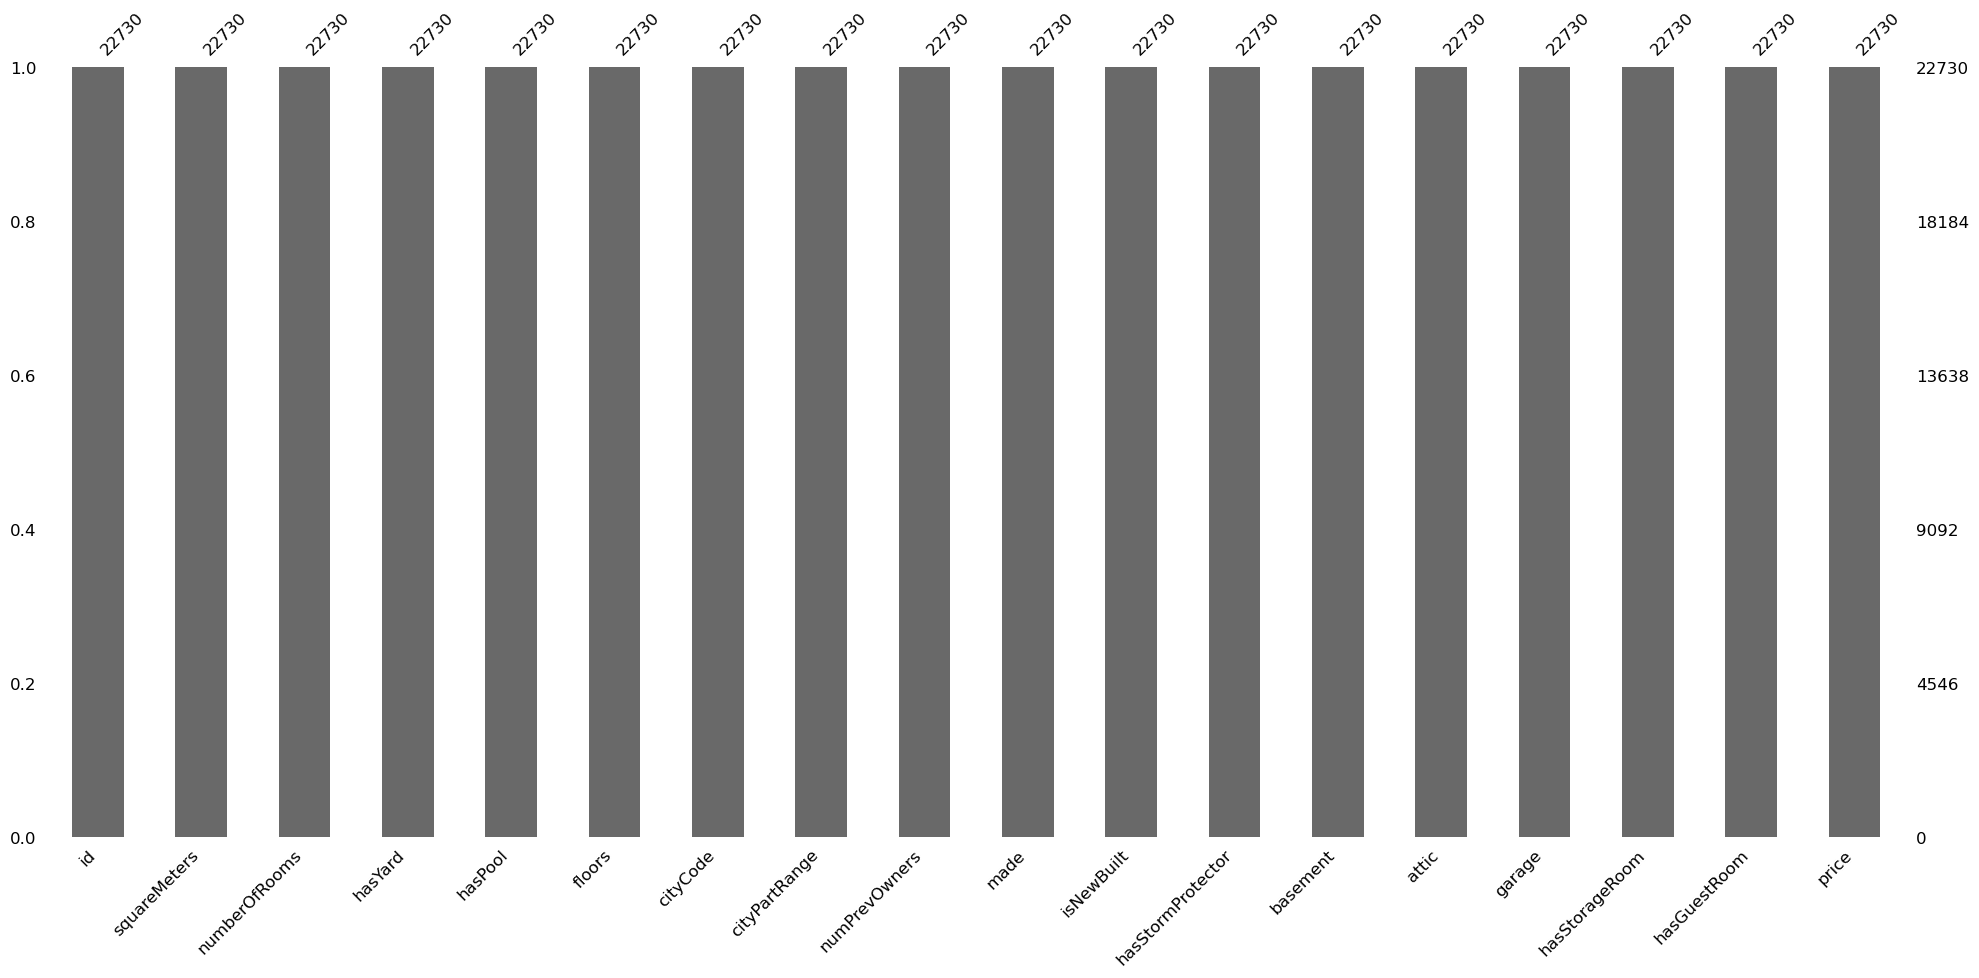

In [9]:
mso.bar(df, fontsize = 12)

In [10]:
print(df.isnull().sum())

id                   0
squareMeters         0
numberOfRooms        0
hasYard              0
hasPool              0
floors               0
cityCode             0
cityPartRange        0
numPrevOwners        0
made                 0
isNewBuilt           0
hasStormProtector    0
basement             0
attic                0
garage               0
hasStorageRoom       0
hasGuestRoom         0
price                0
dtype: int64


In [11]:
df.drop('id', axis = 1, inplace = True)

In [12]:
df.dtypes

squareMeters           int64
numberOfRooms          int64
hasYard                int64
hasPool                int64
floors                 int64
cityCode              object
cityPartRange          int64
numPrevOwners          int64
made                   int64
isNewBuilt             int64
hasStormProtector      int64
basement               int64
attic                  int64
garage                 int64
hasStorageRoom         int64
hasGuestRoom           int64
price                float64
dtype: object

In [13]:
num_col = ["squareMeters", "numberOfRooms", "floors", "made", "basement", "attic", "garage", "price"]

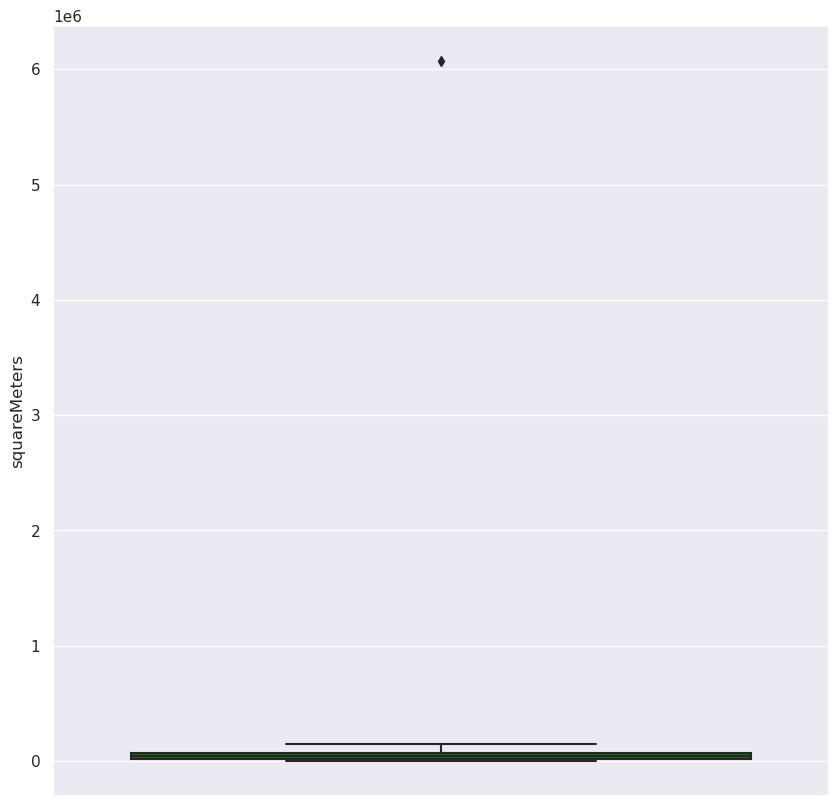

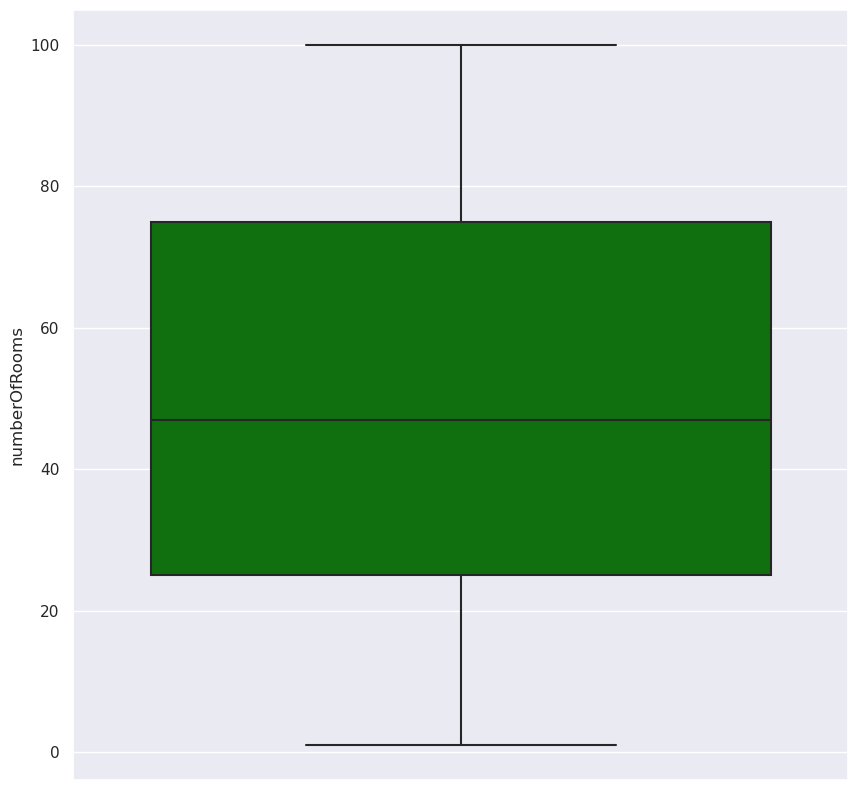

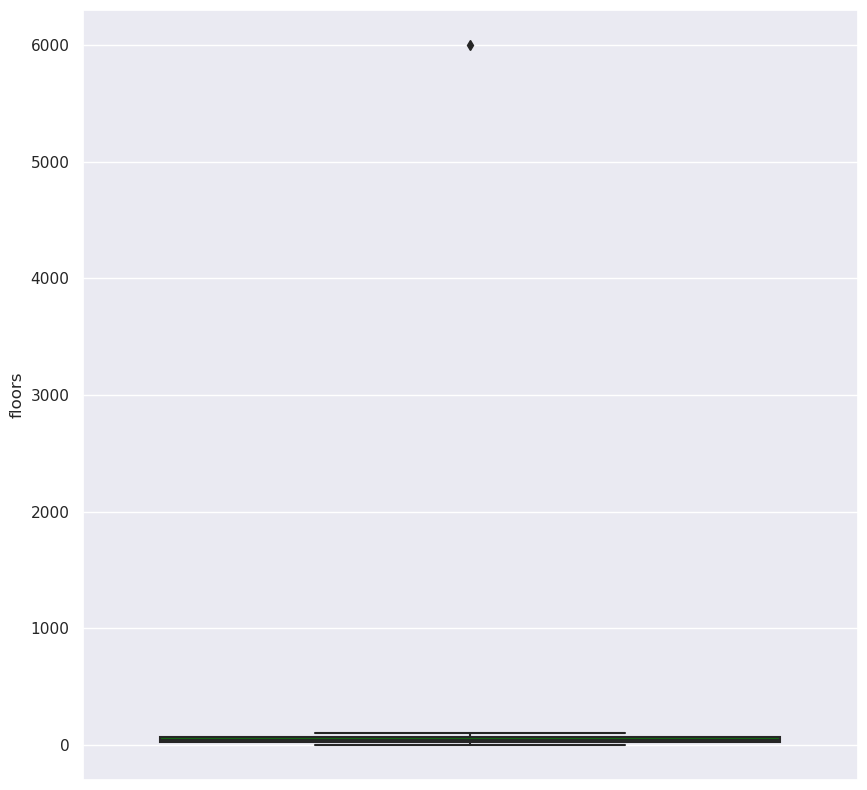

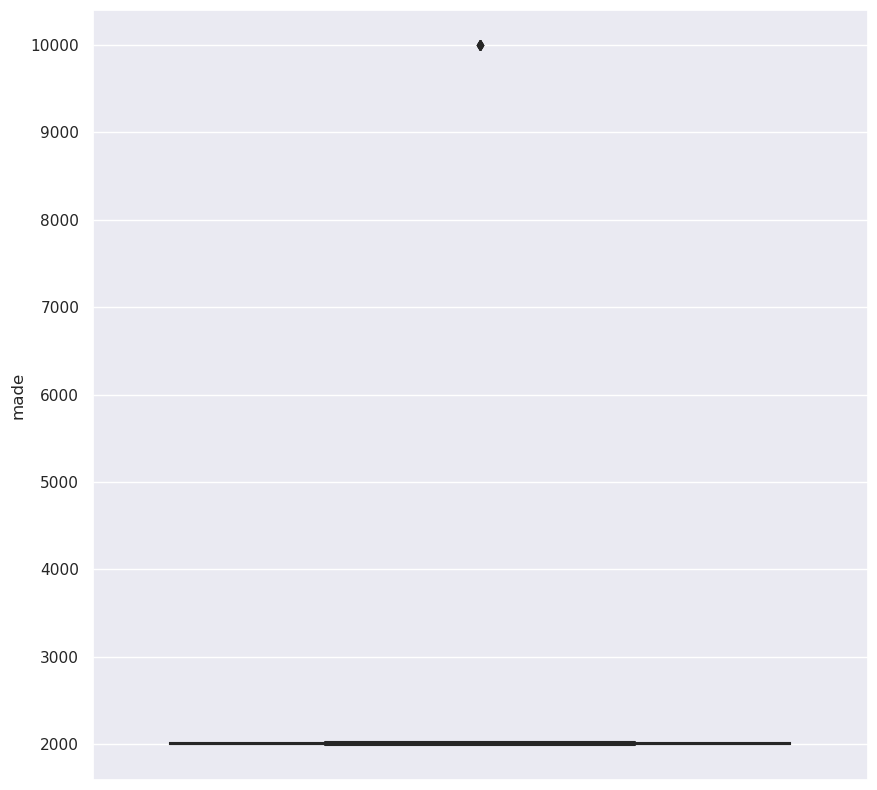

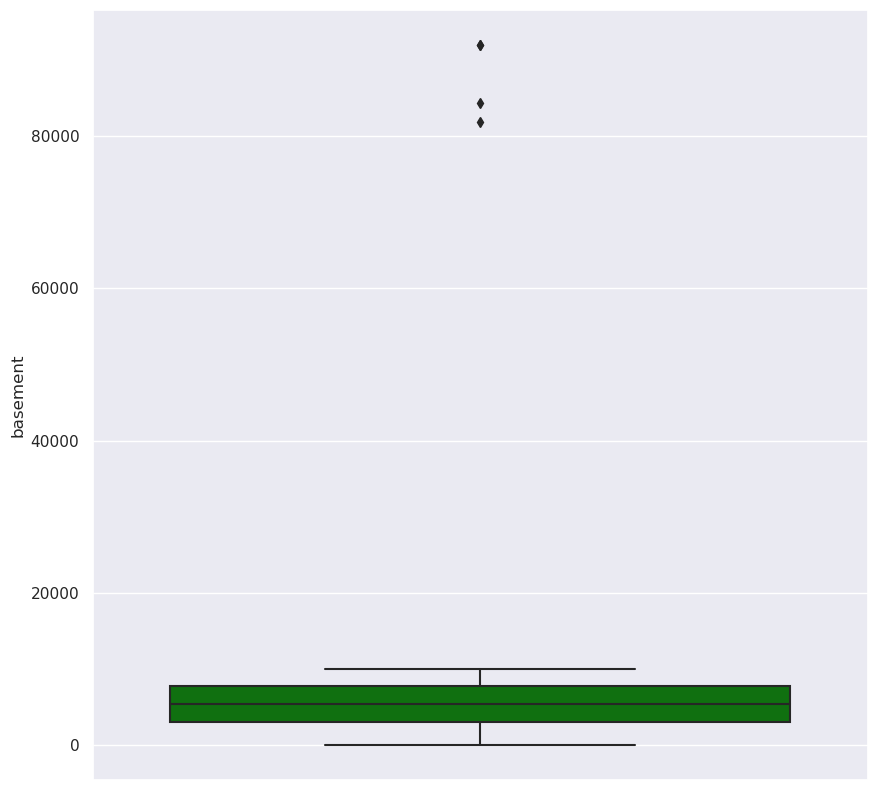

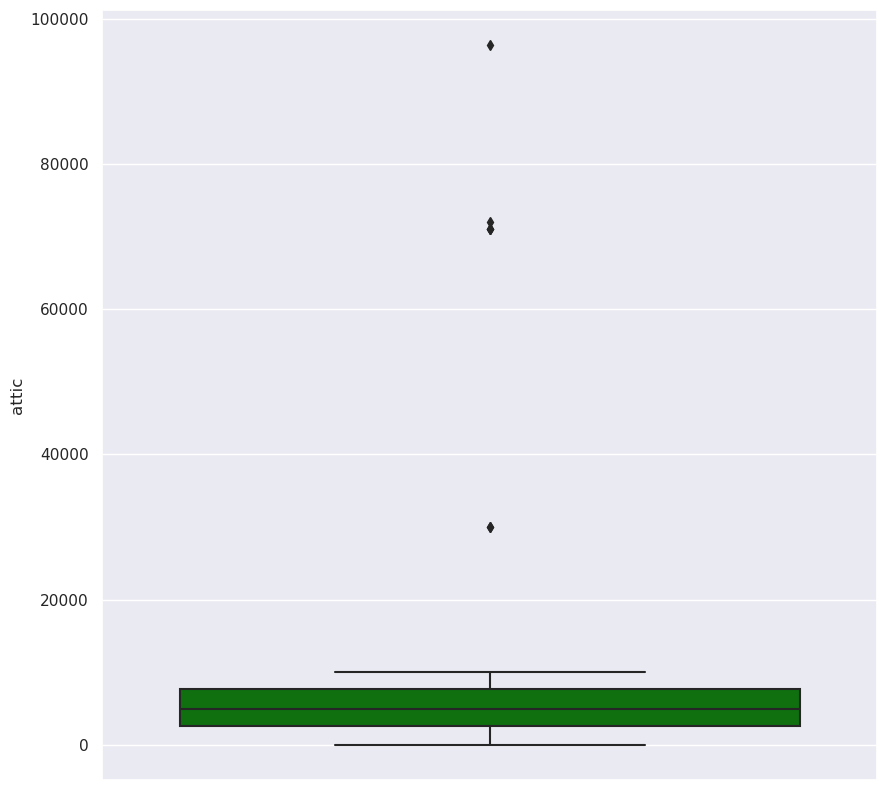

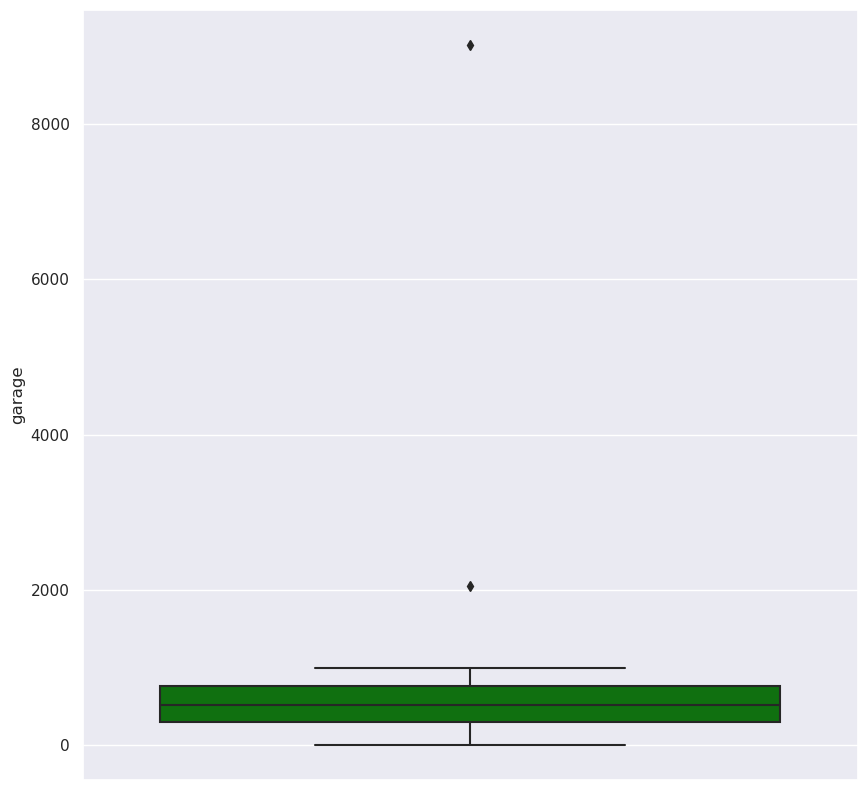

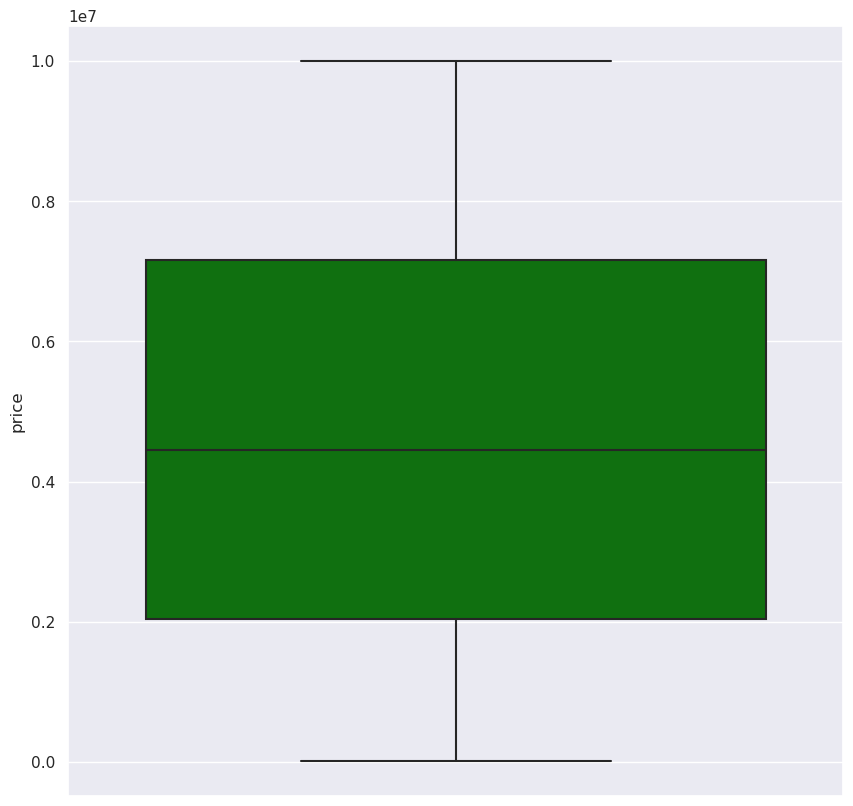

In [14]:
for i in num_col:
    sns.set(style="darkgrid")
    plt.figure(figsize = (10, 10))
    sns.boxplot(data=df, y=i, color='green')

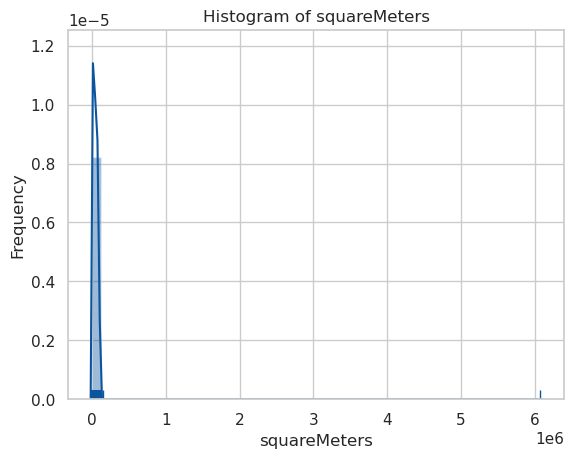

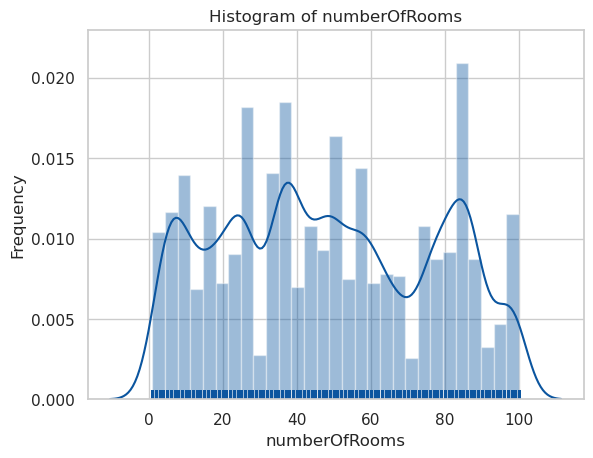

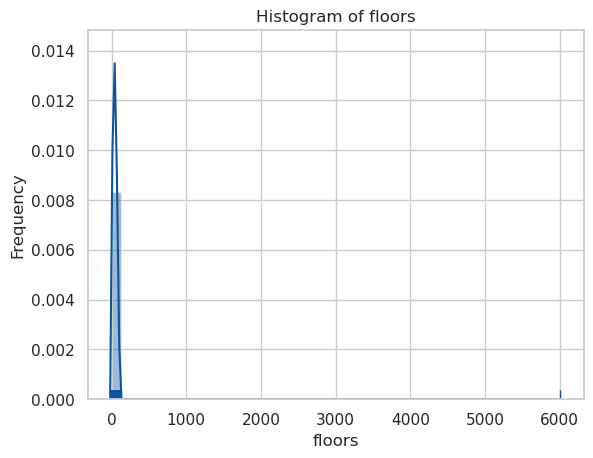

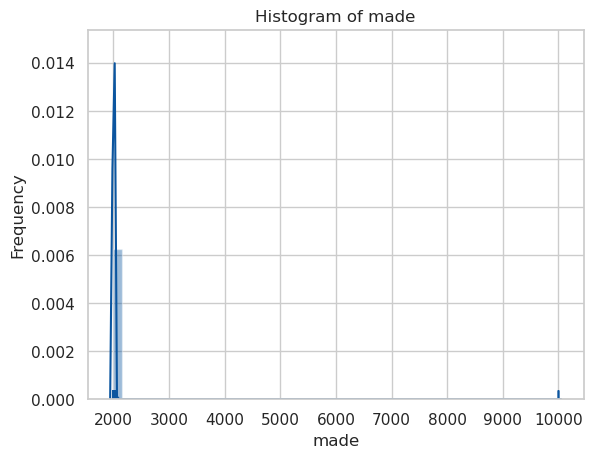

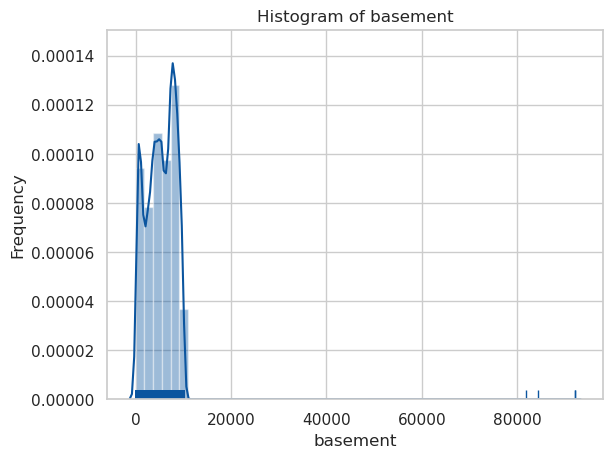

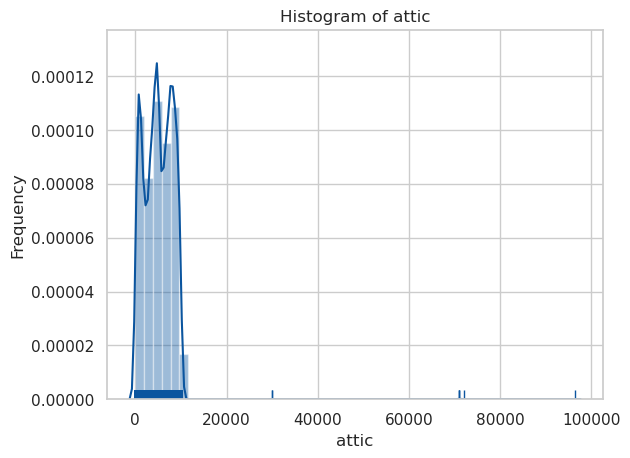

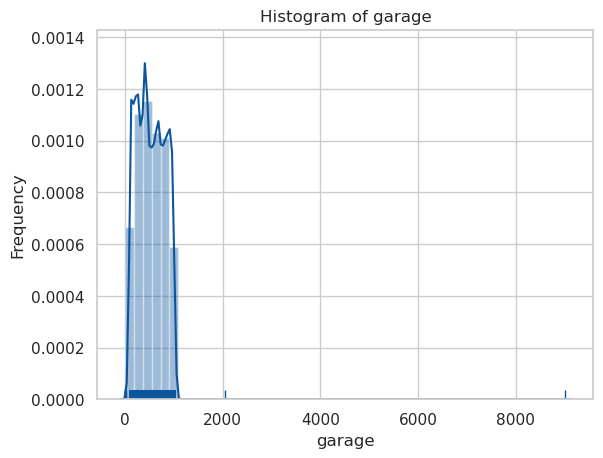

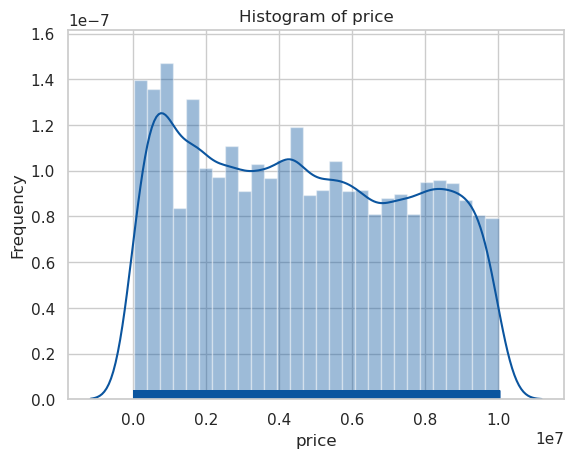

In [15]:
def plot_density_hist(df, cols, hist = False):
    for col in cols:
        sns.set(style="whitegrid", palette='Blues_r')
        sns.distplot(df[col], rug=True, hist = hist)
        plt.title('Histogram of ' + col) # Give the plot a main title
        plt.xlabel(col) # Set text for the x axis
        plt.ylabel('Frequency')# Set text for y axis
        plt.show()
        
plot_density_hist(df, num_col, hist = True)

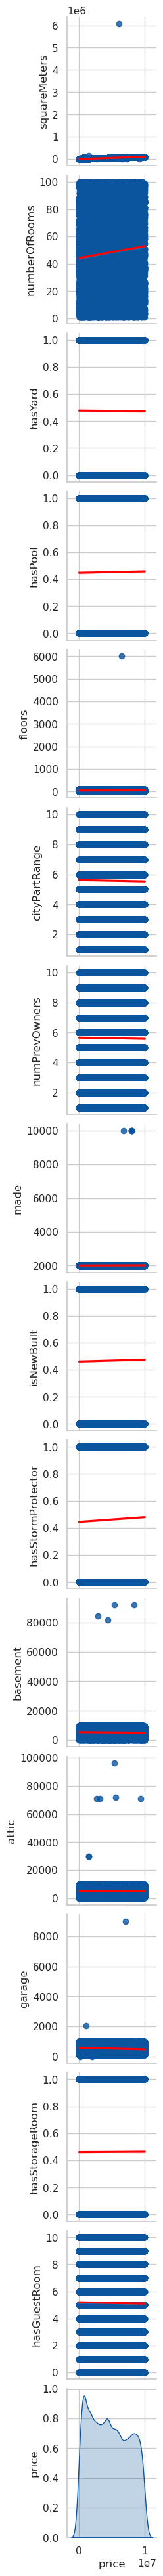

In [16]:
sns.set(style="whitegrid", palette='Blues_r')
sns.pairplot(data= df,x_vars= ["price"], kind='reg', diag_kind='kde',
             plot_kws={'line_kws':{'color':'red'}})

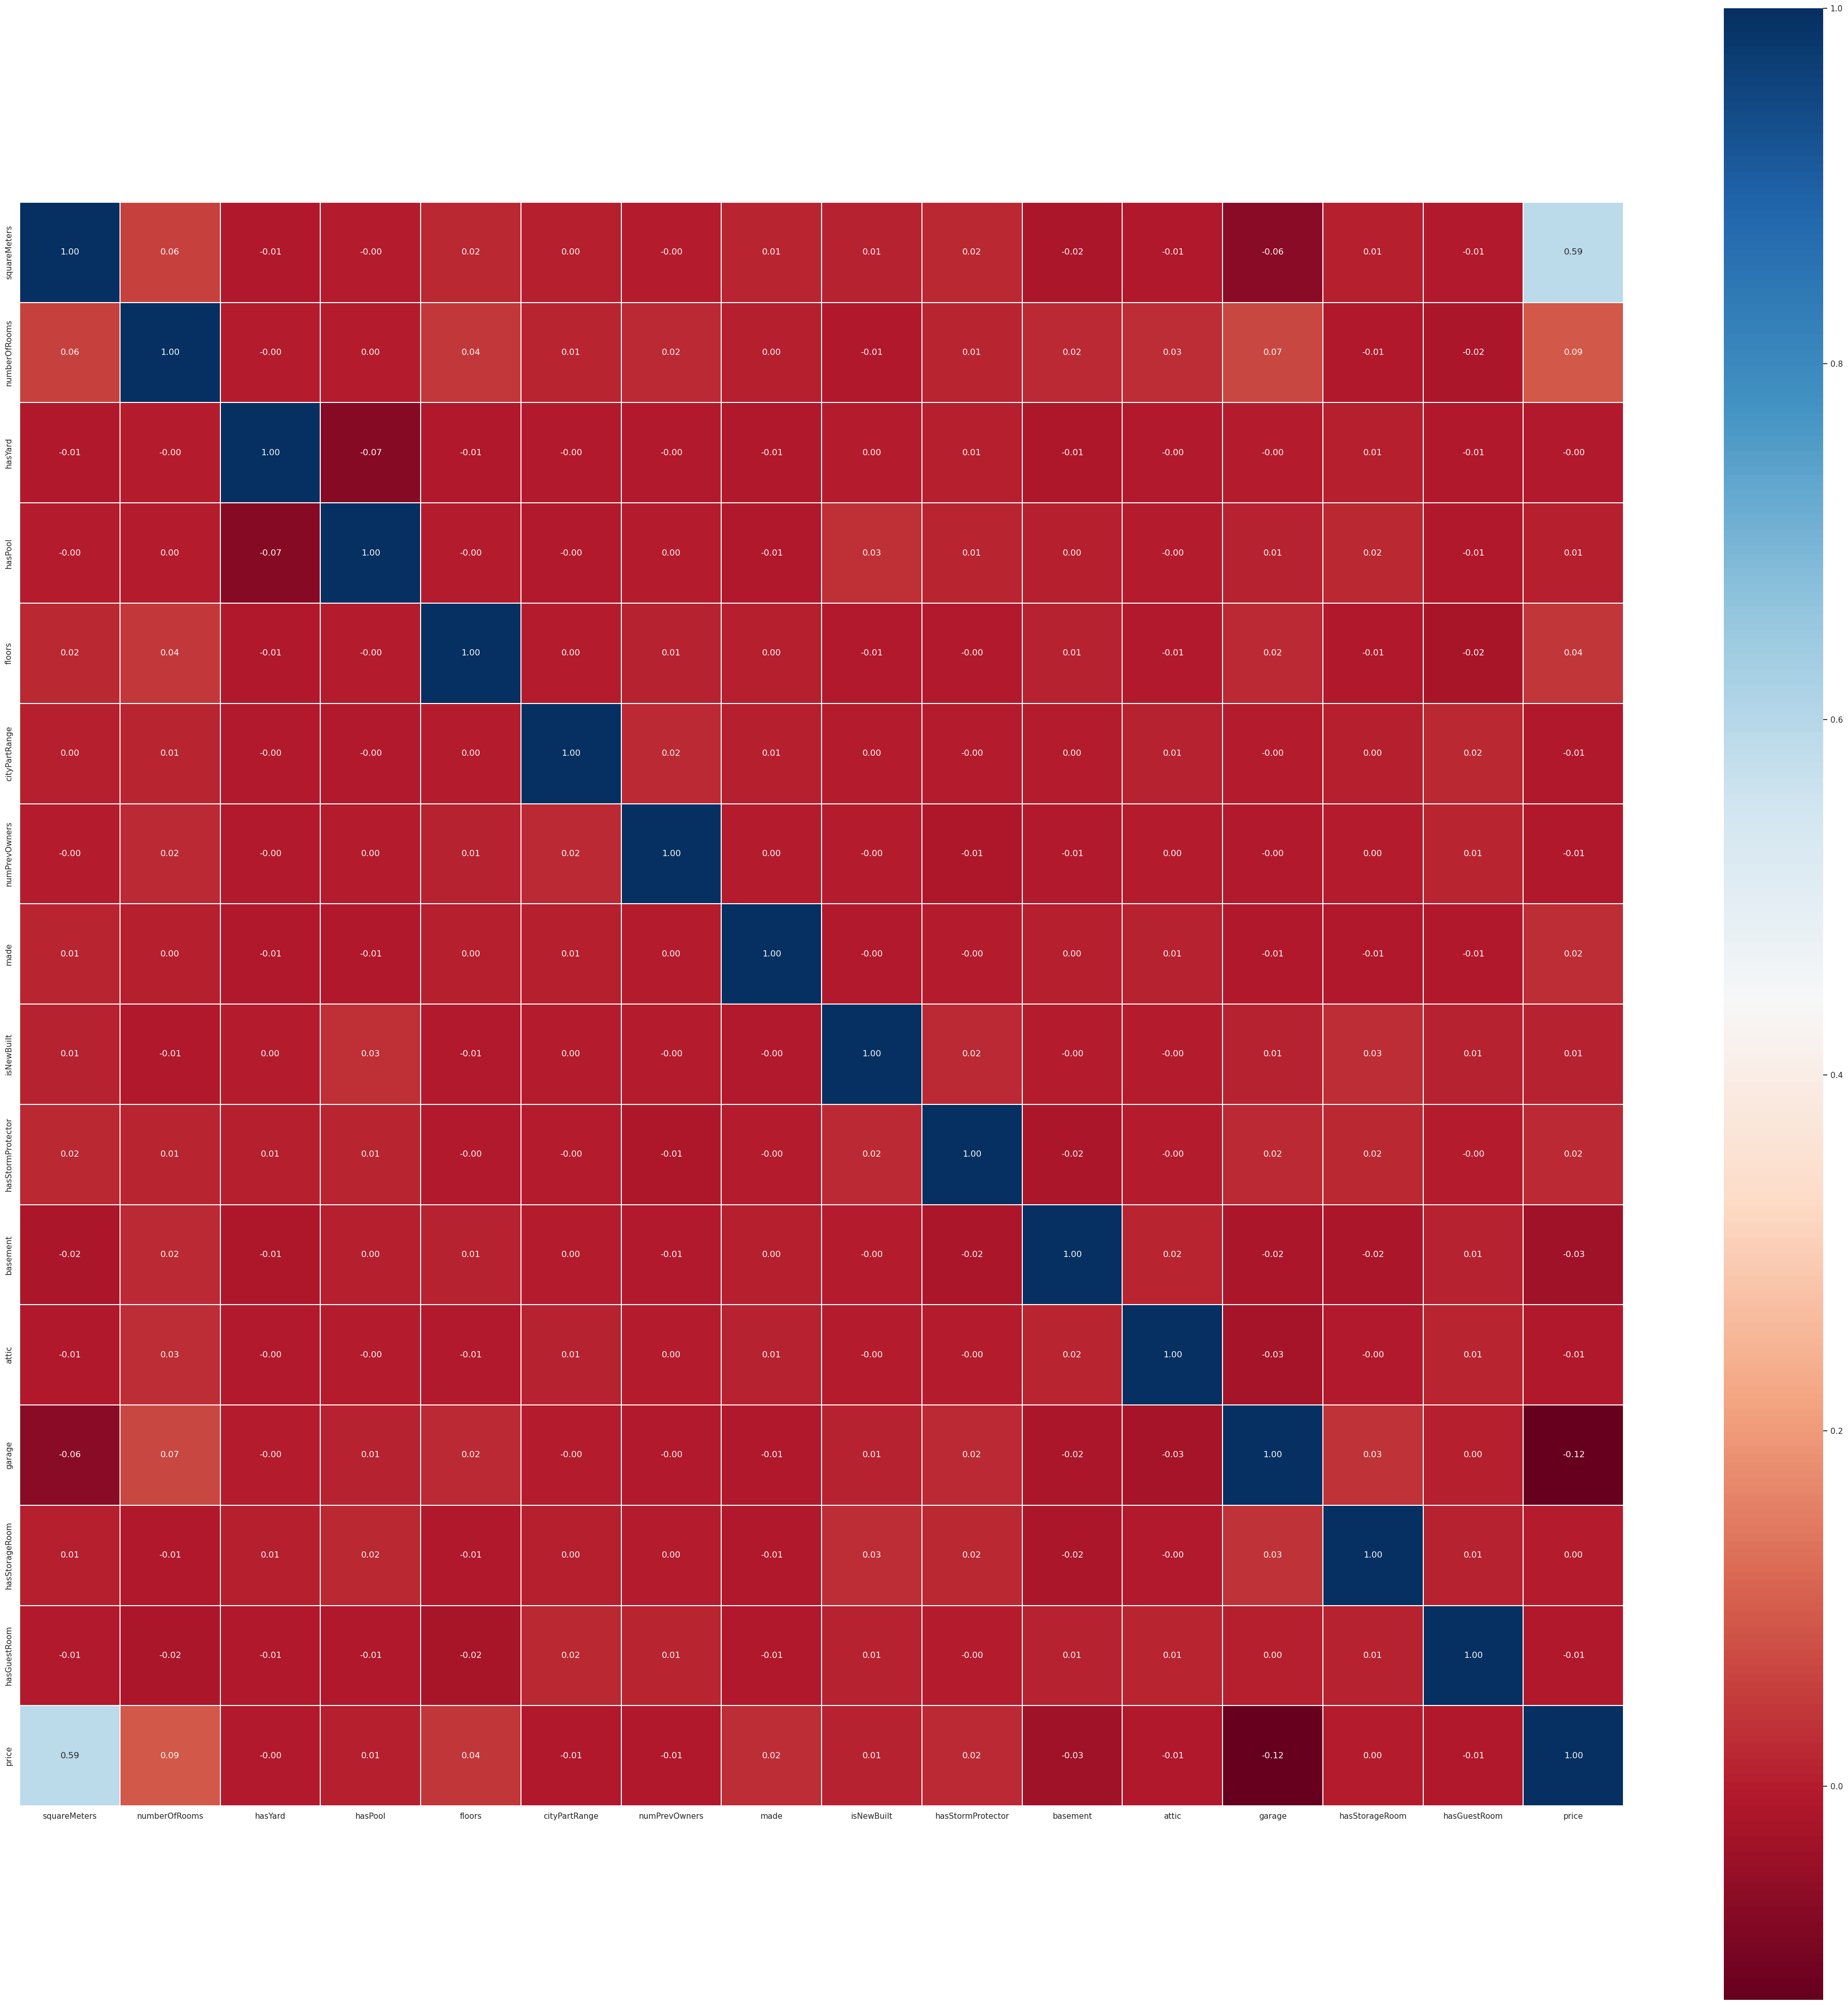

In [17]:
num_corrs = df.corr()
f,ax = plt.subplots(figsize=(50, 50))
sns.heatmap(num_corrs, annot=True, square=True, linewidths=.1, fmt= '.2f',ax=ax, 
           cmap="RdBu")
plt.show()

In [18]:
df.corr()["price"]

squareMeters         0.591749
numberOfRooms        0.091681
hasYard             -0.002545
hasPool              0.006023
floors               0.038374
cityPartRange       -0.009366
numPrevOwners       -0.008546
made                 0.024270
isNewBuilt           0.008080
hasStormProtector    0.020512
basement            -0.034940
attic               -0.006851
garage              -0.120137
hasStorageRoom       0.001567
hasGuestRoom        -0.009309
price                1.000000
Name: price, dtype: float64

In [19]:
df_source.head()

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price,id
0,75523,3,0,1,63,9373,3,8,2005,0,1,4313,9005,956,0,7,7559081.5,1000000
1,80771,39,1,1,98,39381,8,6,2015,1,0,3653,2436,128,1,2,8085989.5,1000001
2,55712,58,0,1,19,34457,6,8,2021,0,0,2937,8852,135,1,9,5574642.1,1000002
3,32316,47,0,0,6,27939,10,4,2012,0,1,659,7141,359,0,3,3232561.2,1000003
4,70429,19,1,1,90,38045,3,7,1990,1,0,8435,2429,292,1,4,7055052.0,1000004


In [20]:
df_train = df.copy()

In [21]:
df_train['cityCode'] = df_train['cityCode'].str.zfill(5)
df_test['cityCode'] = df_train['cityCode'].str.zfill(5)
df_source['cityCode'] = df_train['cityCode'].str.zfill(5)

In [22]:
num_cols = df_train.select_dtypes(include=np.number).columns.tolist()
num_cols.remove('price')

In [23]:
made = pd.DataFrame(df_train.groupby(['made']).size()).reset_index().rename(columns = {0:'Count'})
made = made[made['made']< 5000]

made1 = pd.DataFrame(df_train.groupby(['made'])['price'].mean()).reset_index().rename(columns = {0:'mean_price'})

made = pd.merge(made,made1, on = 'made', how = 'inner')

In [24]:
df_train = pd.concat([df_train,df_source])

In [25]:
train_1 = df_train[df_train['made']<=2000]
test_1 = df_test[df_test['made']<=2000]
train_2 = df_train[(df_train['made']>=2001) & (df_train['made']<=2007)]
test_2 = df_test[(df_test['made']>=2001) & (df_test['made']<=2007)]
train_3 = df_train[df_train['made']>2007]
test_3 = df_test[df_test['made']>2007]

In [26]:
train_1 = pd.merge(train_1,made[['made','Count']], on = 'made', how = 'inner')
test_1 = pd.merge(test_1,made[['made','Count']], on = 'made', how = 'inner')

In [27]:
train_2 = pd.merge(train_2,made[['made','Count']], on = 'made', how = 'inner')
test_2 = pd.merge(test_2,made[['made','Count']], on = 'made', how = 'inner')

In [28]:
train_3 = pd.merge(train_3,made[['made','Count']], on = 'made', how = 'inner')
test_3 = pd.merge(test_3,made[['made','Count']], on = 'made', how = 'inner')

In [29]:
num_cols = num_cols + ['Count']

In [30]:
num_cols

['squareMeters',
 'numberOfRooms',
 'hasYard',
 'hasPool',
 'floors',
 'cityPartRange',
 'numPrevOwners',
 'made',
 'isNewBuilt',
 'hasStormProtector',
 'basement',
 'attic',
 'garage',
 'hasStorageRoom',
 'hasGuestRoom',
 'Count']

In [31]:
X1 = train_1[num_cols]
y1 = train_1['price']

model=XGBRegressor(max_depth=3, learning_rate=0.24 , n_estimators=2000, objective='reg:linear', booster='gbtree')
XGB=model.fit(X1,y1)


X_test = test_1[num_cols]
prediction=XGB.predict(X_test)

test_1['price'] = prediction
test_1

[23:58:56] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


,id,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,Count,price
0,22730,47580,89,0,1,8,35693,5,3,1995,0,0,6885,8181,241,0,8,631,4758011.000
1,22751,69856,47,0,1,26,77004,1,8,1995,1,0,17,853,854,1,8,631,6995771.000
2,22755,23608,51,0,0,31,84602,10,6,1995,1,0,6410,8153,945,1,8,631,2364168.250
3,22775,67724,11,1,1,64,51336,2,10,1995,0,1,7448,1932,128,1,2,631,6778856.500
4,22815,50778,39,0,1,94,49199,2,1,1995,0,0,5294,7178,614,0,2,631,5074851.500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5584,35303,84696,45,0,0,14,24522,7,4,1991,0,1,8681,5246,524,1,6,30,8468765.000
5585,35522,42630,34,0,1,25,37363,9,7,1991,1,0,7976,331,236,0,0,30,4239987.000
5586,35686,18316,20,0,1,5,28086,2,6,1991,0,0,6574,2166,127,1,5,30,1847247.375
5587,36267,41700,48,0,1,8,84704,5,7,1991,0,0,743,7716,194,1,2,30,4206274.500


In [32]:
X2 = train_2[num_cols]
y2 = train_2['price']

model=XGBRegressor(max_depth=3, learning_rate=0.24 , n_estimators=2000, objective='reg:linear', booster='gbtree')
XGB=model.fit(X2,y2)

X_test = test_2[num_cols]
prediction=XGB.predict(X_test)

test_2['price'] = prediction
test_2

[23:59:09] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


,id,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,Count,price
0,22740,69567,38,0,0,11,54900,8,3,2003,0,1,8194,8627,124,0,3,1156,6966366.00
1,22776,15351,34,0,0,10,68109,3,6,2003,0,0,6341,5844,929,1,6,1156,1544070.75
2,22868,4198,6,1,0,80,38929,3,8,2003,0,0,3795,4194,885,1,8,1156,405859.50
3,22887,62064,86,1,1,35,48037,2,3,2003,1,0,8000,2600,976,0,10,1156,6180837.50
4,22907,91618,4,0,0,36,74838,8,3,2003,1,1,6484,2731,121,1,5,1156,9159348.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3225,36015,73748,84,0,0,32,85082,5,2,2001,1,1,4309,7379,273,1,9,59,7383201.50
3226,36030,90170,63,1,1,20,04081,9,5,2001,1,0,4196,2528,945,1,3,59,9012547.00
3227,36156,41700,8,0,0,64,53916,7,9,2001,1,0,8163,8153,194,0,8,59,4174734.75
3228,36298,55620,61,1,1,90,66390,3,4,2001,1,1,9867,7179,548,0,1,59,5568641.50


In [33]:
X3 = train_3[num_cols]
y3 = train_3['price']

model=XGBRegressor(max_depth=3, learning_rate=0.24 , n_estimators=2000, objective='reg:linear', booster='gbtree')
XGB=model.fit(X3,y3)

X_test = test_3[num_cols]
prediction=XGB.predict(X_test)

test_3['price'] = prediction
test_3

[23:59:19] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


,id,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,Count,price
0,22733,16354,47,1,1,9,15113,6,5,2019,1,1,705,5097,122,1,5,956,1644086.750
1,22748,35423,52,1,1,24,72385,6,8,2019,1,0,8486,4375,489,1,5,956,3558887.000
2,22820,85256,74,0,1,39,50147,1,1,2019,0,1,3945,5240,745,1,0,956,8520852.000
3,22826,68847,74,1,1,80,22176,10,6,2019,0,1,9789,9476,847,1,5,956,6885240.000
4,22840,15815,13,1,1,7,22460,7,3,2019,1,1,2494,8575,827,1,5,956,1570423.875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6330,36857,54484,38,1,1,78,52734,8,6,2011,0,1,8235,8136,114,1,8,68,5453139.500
6331,37118,54484,25,1,0,94,46686,4,5,2011,0,1,8163,8889,241,0,6,68,5447892.000
6332,37278,27949,84,1,0,94,98846,5,9,2011,1,1,8578,9248,245,1,1,68,2789866.750
6333,37431,76932,85,0,1,89,16768,5,4,2011,0,0,8767,8149,583,1,0,68,7705767.000


In [34]:
X1_ = train_1[num_cols]
y1_ = train_1[['price']]

In [35]:
X2_ = train_2[num_cols]
y2_ = train_2[['price']]

In [36]:
X3_ = train_3[num_cols]
y3_ = train_3[['price']]

In [37]:
X_test1 = test_1[num_cols]
X_test2 = test_2[num_cols]
X_test3 = test_3[num_cols]

In [38]:
scaler = preprocessing.StandardScaler().fit(X1_)
X1_ = scaler.transform(X1_)

In [39]:
scaler = preprocessing.StandardScaler().fit(X2_)
X2_ = scaler.transform(X2_)

In [40]:
scaler = preprocessing.StandardScaler().fit(X3_)
X3_ = scaler.transform(X3_)

In [41]:
GBoost = GradientBoostingRegressor()
model_xgb = xgb.XGBRegressor()
model_lgb = lgb.LGBMRegressor(objective='regression', num_leaves = 32,
                              learning_rate=0.01)

In [42]:
nr.seed(265)
inside = ms.KFold(n_splits=5, shuffle = True)
nr.seed(562)
outside = ms.KFold(n_splits=5, shuffle = True)

nr.seed(2652)
## Define the dictionary for the grid search and the model object to search on
param_grid = {'n_estimators': [2000, 3000]}

## Perform the grid search over the parameters
gsearch = ms.GridSearchCV(estimator = model_lgb, param_grid = param_grid, 
                      cv = inside, # Use the inside folds
                      scoring = 'r2',
                      return_train_score = True)

In [43]:
gsearch.fit(X1_, y1_)
gsearch.best_params_, gsearch.best_score_

({'n_estimators': 2000}, 0.9978194656799786)

In [44]:
gsearch.fit(X2_, y2_)
gsearch.best_params_, gsearch.best_score_

({'n_estimators': 2000}, 0.9959393003412644)

In [45]:
gsearch.fit(X3_, y3_)
gsearch.best_params_, gsearch.best_score_

({'n_estimators': 3000}, 0.997249992582946)

In [46]:
model_xgb = xgb.XGBRegressor(max_depth = 3, min_child_weight = 0, gamma = 0, 
                           subsample = 0.8, colsample_bytree = 0.8, 
                           scale_pos_weight = 1, reg_lambda = 1,
                           learning_rate =0.24, n_estimators=2000, 
                           objective='reg:linear', booster='gbtree', seed = 14)

In [47]:
model_xgb1 = xgb.XGBRegressor(max_depth = 3, min_child_weight = 0, gamma = 0, 
                           subsample = 0.8, colsample_bytree = 0.8, 
                           scale_pos_weight = 1, reg_lambda = 1,
                           learning_rate =0.24, n_estimators=3000, 
                           objective='reg:linear', booster='gbtree', seed = 14)

In [48]:
scaler = preprocessing.StandardScaler().fit(X_test1)
X_test1_ = scaler.transform(X_test1)

In [49]:
scaler = preprocessing.StandardScaler().fit(X_test2)
X_test2_ = scaler.transform(X_test2)

In [50]:
scaler = preprocessing.StandardScaler().fit(X_test3)
X_test3_ = scaler.transform(X_test3)

In [51]:
XGB1=model_xgb.fit(X1_,y1_)
prediction=XGB1.predict(X_test1_)

test_1['price'] = prediction
test_1

[00:08:12] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


,id,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,Count,price
0,22730,47580,89,0,1,8,35693,5,3,1995,0,0,6885,8181,241,0,8,631,5134380.00
1,22751,69856,47,0,1,26,77004,1,8,1995,1,0,17,853,854,1,8,631,7382171.00
2,22755,23608,51,0,0,31,84602,10,6,1995,1,0,6410,8153,945,1,8,631,2677513.25
3,22775,67724,11,1,1,64,51336,2,10,1995,0,1,7448,1932,128,1,2,631,7166696.00
4,22815,50778,39,0,1,94,49199,2,1,1995,0,0,5294,7178,614,0,2,631,5471734.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5584,35303,84696,45,0,0,14,24522,7,4,1991,0,1,8681,5246,524,1,6,30,8874531.00
5585,35522,42630,34,0,1,25,37363,9,7,1991,1,0,7976,331,236,0,0,30,4608028.00
5586,35686,18316,20,0,1,5,28086,2,6,1991,0,0,6574,2166,127,1,5,30,2127861.25
5587,36267,41700,48,0,1,8,84704,5,7,1991,0,0,743,7716,194,1,2,30,4532507.00


In [52]:
XGB1=model_xgb.fit(X2_,y2_)
prediction=XGB1.predict(X_test2_)

test_2['price'] = prediction
test_2

[00:08:36] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


,id,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,Count,price
0,22740,69567,38,0,0,11,54900,8,3,2003,0,1,8194,8627,124,0,3,1156,6.974490e+06
1,22776,15351,34,0,0,10,68109,3,6,2003,0,0,6341,5844,929,1,6,1156,1.578161e+06
2,22868,4198,6,1,0,80,38929,3,8,2003,0,0,3795,4194,885,1,8,1156,4.809942e+05
3,22887,62064,86,1,1,35,48037,2,3,2003,1,0,8000,2600,976,0,10,1156,6.199954e+06
4,22907,91618,4,0,0,36,74838,8,3,2003,1,1,6484,2731,121,1,5,1156,9.174033e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3225,36015,73748,84,0,0,32,85082,5,2,2001,1,1,4309,7379,273,1,9,59,7.410649e+06
3226,36030,90170,63,1,1,20,04081,9,5,2001,1,0,4196,2528,945,1,3,59,9.050730e+06
3227,36156,41700,8,0,0,64,53916,7,9,2001,1,0,8163,8153,194,0,8,59,4.188572e+06
3228,36298,55620,61,1,1,90,66390,3,4,2001,1,1,9867,7179,548,0,1,59,5.600940e+06


In [53]:
XGB1=model_xgb1.fit(X3_,y3_)
prediction=XGB1.predict(X_test3_)


test_3['price'] = prediction
test_3

[00:08:54] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


,id,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,Count,price
0,22733,16354,47,1,1,9,15113,6,5,2019,1,1,705,5097,122,1,5,956,1.873590e+04
1,22748,35423,52,1,1,24,72385,6,8,2019,1,0,8486,4375,489,1,5,956,2.311227e+06
2,22820,85256,74,0,1,39,50147,1,1,2019,0,1,3945,5240,745,1,0,956,9.999184e+06
3,22826,68847,74,1,1,80,22176,10,6,2019,0,1,9789,9476,847,1,5,956,9.086278e+06
4,22840,15815,13,1,1,7,22460,7,3,2019,1,1,2494,8575,827,1,5,956,7.424344e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6330,36857,54484,38,1,1,78,52734,8,6,2011,0,1,8235,8136,114,1,8,68,6.179963e+06
6331,37118,54484,25,1,0,94,46686,4,5,2011,0,1,8163,8889,241,0,6,68,6.150365e+06
6332,37278,27949,84,1,0,94,98846,5,9,2011,1,1,8578,9248,245,1,1,68,7.838229e+05
6333,37431,76932,85,0,1,89,16768,5,4,2011,0,0,8767,8149,583,1,0,68,1.000017e+07


In [54]:
submission = pd.concat([test_1,test_2,test_3])
submission = submission[['id','price']]
submission = submission.sort_values(by = ['id'])
submission.to_csv('submission.csv',index = False)
submission.head()

,id,price
0,22730,5.134380e+06
402,22731,6.557354e+06
827,22732,9.476783e+06
0,22733,1.873590e+04
685,22734,8.790494e+06
